<a href="https://colab.research.google.com/github/DrakeData/Image_Classification/blob/main/Image_Classification_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8: Image Classification

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import shutil
import tensorflow as tf
import sys

## Ingest
Donwloading the data from Kaggle's API

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

 97% 264M/271M [00:02<00:00, 116MB/s]
100% 271M/271M [00:02<00:00, 126MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 116MB/s]
 98% 533M/544M [00:05<00:00, 99.3MB/s]
100% 544M/544M [00:05<00:00, 102MB/s] 


In [7]:
! unzip train.zip 
# &> /dev/null

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

## EDA

### Image Sample
First, let's take a quick look at some of the images.

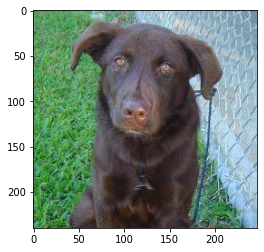

In [8]:
# Random image Check
filenames = os.listdir("./train")
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image);

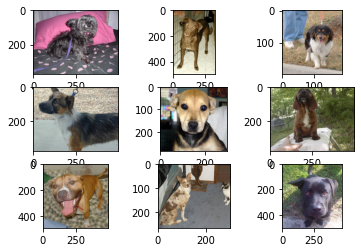

In [9]:
# Dog image comparison check

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = os.path.join('train', 'dog.'+str(i)+'.jpg')
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

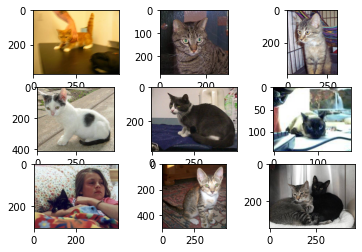

In [10]:
# Cat image comparison check

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = os.path.join('train', 'cat.'+str(i)+'.jpg')
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

Looking at the sample images, we can see that the photos come in many different shapes and sizes. There are also pictures that have more than one animal in them or that the cat/dog is not directly in the middle of the picture. We will have to keep this in mind for when we build our classification model as we will need to standardized the photo size.

### Total Count Check
Look to see how many dog/cat images we have in the training set.

In [11]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [12]:
df.head()

,filename,category
0,dog.10978.jpg,1
1,dog.7618.jpg,1
2,cat.6411.jpg,0
3,dog.3352.jpg,1
4,dog.7893.jpg,1


In [13]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

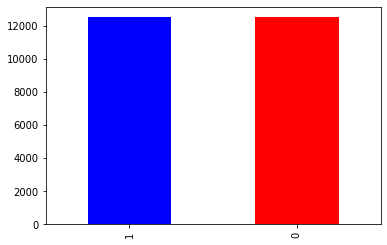

In [14]:
df['category'].value_counts().plot.bar(color=['blue', 'red']);

There is an equal amount of dog and cat images in our training set (12,500 each).

### Standardize Images
Before running the images through a model, we will want to standardize them to 200×200 pixels. This will improve the training speed of the model.

In [15]:
# create directories for standardized test and train images
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train', 'test']

for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs', 'cats']
	for labldir in labeldirs:
		newdir = os.path.join(dataset_home, subdir, labldir)
		os.makedirs(newdir, exist_ok=True)

In [16]:
# seed random number generator
random.seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = 'train'

for file in os.listdir(src_directory):
	src = os.path.join(src_directory, file)
	dst_dir = 'train'
	if random.random() < val_ratio:
		dst_dir = 'test'
	if file.startswith('cat'):
		dst =  os.path.join(dataset_home, dst_dir, 'cats', file)
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = os.path.join(dataset_home, dst_dir, 'dogs', file)
		shutil.copyfile(src, dst)

## Models

In [17]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [18]:
# define model
model = define_model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [20]:
# prepare iterators
train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [21]:
# fit model
history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
	validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# evaluate model
_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
print(f'Accuracy Score: { acc* 100.0}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Accuracy Score: 72.55275249481201


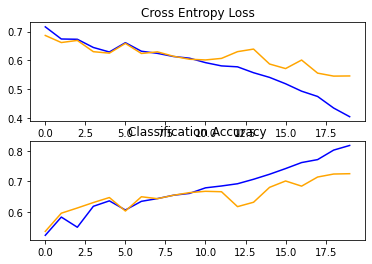

In [42]:
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
# # save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()

In [24]:
import pickle

pickle.dump(history, open('drive/MyDrive/Colab Notebooks/Image_Classification/model1.pkl','wb'))

INFO:tensorflow:Assets written to: ram://be439273-32da-4276-8c1c-326aa06a8058/assets


In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')